## $\textbf{Biscuit Classification}$

+ Train a machine learning model that classifies biscuits.

In [1]:
# Import required libraries.
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import uniform
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, cohen_kappa_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from torch import float32, int64, tensor
from torch.utils.data import DataLoader, TensorDataset

# Import local modules.
from classifier import FNNClassifier

### $\textbf{1. Dunking Data Preprocessing}$

+ Perform preprocessing on the ***dunking*** data (```dunking.csv```).
+ This data will be used as the training and testing data for the machine 
learning models.

In [2]:
# Read in the dunking data.
dunking = pd.read_csv("../datasets/dunking-data/dunking.csv")

# View the data.
print(dunking.head().to_markdown())

|    |   surface-tension |   contact-angle |   dynamic-viscosity |   travel-distance |   dunking-time | biscuit   |
|---:|------------------:|----------------:|--------------------:|------------------:|---------------:|:----------|
|  0 |         0.0738967 |         1.33301 |         0.000998733 |        0.0111961  |        19.3622 | Digestive |
|  1 |         0.0809462 |         1.47676 |         0.00101176  |        0.00589433 |        11.8526 | Digestive |
|  2 |         0.0874079 |         1.47714 |         0.000983589 |        0.00924863 |        24.7937 | Digestive |
|  3 |         0.070793  |         1.502   |         0.0010016   |        0.00377375 |        16.2928 | Hobnob    |
|  4 |         0.0589175 |         1.54827 |         0.00100433  |        0.00229071 |        13.6623 | Hobnob    |


#### $\textbf{1.1 PCA?}$

+ Investigate if ***PCA*** could be useful to reduce the number of features.

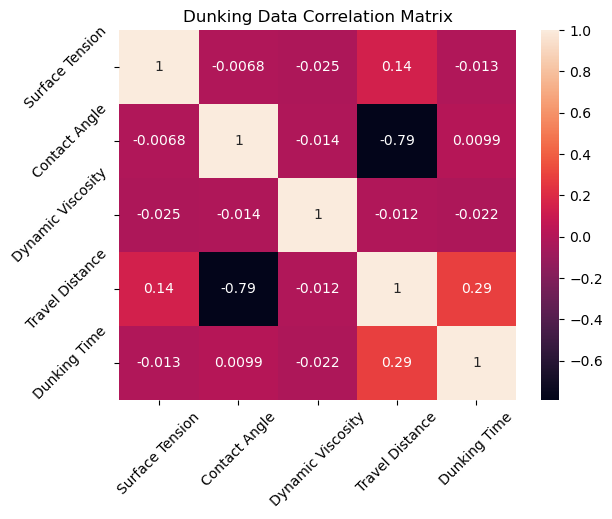

In [3]:
# Calculate the correlation matrix.
corr_matrix = dunking.drop("biscuit", axis="columns").corr()

# Plot the correlation matrix.
fig, ax = plt.subplots()

# Set the labels for the plot.
labels = ("Surface Tension", 
          "Contact Angle", 
          "Dynamic Viscosity", 
          "Travel Distance", 
          "Dunking Time")

# Plot the correlation matrix.
sns.heatmap(data=corr_matrix, 
            annot=True, 
            xticklabels=labels,
            yticklabels=labels,
            ax=ax)

# Set the title.
ax.set_title("Dunking Data Correlation Matrix")

# Rotate the labels.
ax.tick_params(rotation=45)

plt.show()

##### $\textbf{1.1.1 Observations}$

+ The correlation matrix shows that the features in the dunking data do not 
have strong correlations.
+ The main exception being the travel distance and contact angle, which we 
identified in the ***exploration*** notebook.

- The weak correlations suggest that PCA will not be that useful in the context 
of this data.

#### $\textbf{1.2 Preprocessing}$

+ Preprocess the ***dunking*** data.

- Split the data into training and testing subsets.
- Standardise the features in the different subsets.

In [4]:
# Encode the biscuits to integer labels.
encoder = LabelEncoder()
dunking["encoded-biscuit"] = encoder.fit_transform(dunking["biscuit"])

# Store the decoded labels.
biscuit_decoded = encoder.classes_

In [5]:
# Split the dunking data into train and test subsets.
dunk_train, dunk_test = train_test_split(dunking, train_size=0.80, shuffle=True)

# Split the train subset into features and targets.
dunk_train_features = dunk_train.drop(["biscuit", "encoded-biscuit"], axis="columns")
dunk_train_targets = dunk_train["encoded-biscuit"]

# Split the test subset into features and targets.
dunk_test_features = dunk_test.drop(["biscuit", "encoded-biscuit"], axis="columns")
dunk_test_targets = dunk_test["encoded-biscuit"]

In [6]:
# Standardise the train features.
dunk_train_features_scaled = StandardScaler().fit_transform(dunk_train_features)
dunk_train_features_scaled = pd.DataFrame(dunk_train_features_scaled, columns=dunk_train_features.columns)

# Standardise the test features.
dunk_test_features_scaled = StandardScaler().fit_transform(dunk_test_features)
dunk_test_features_scaled = pd.DataFrame(dunk_test_features_scaled, columns=dunk_test_features.columns)

### $\textbf{2. Support Vector Machines}$

+ Investigate how a ***Support Vector Classifier (SVC)*** performs.

#### $\textbf{2.1 Initial Model}$

+ Define an initial ***SVC*** model.

In [7]:
# Create a Support Vector Classifier (SVC) model.
svc = SVC(kernel="rbf")

# Train the SVC model.
svc.fit(dunk_train_features_scaled, dunk_train_targets)

# Test the SVC model.
svc_predicted_targets = svc.predict(dunk_test_features_scaled)

In [8]:
# Print the classification report.
print(classification_report(dunk_test_targets, svc_predicted_targets, target_names=biscuit_decoded))

              precision    recall  f1-score   support

   Digestive       0.88      0.89      0.88       184
      Hobnob       0.84      0.77      0.81       217
    Rich Tea       0.85      0.92      0.88       199

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



In [9]:
# Calculate the F1 score.
svc_f1 = f1_score(dunk_test_targets, svc_predicted_targets, average="macro")
print(f"SVC F1 Score: {svc_f1:.5f}")

SVC F1 Score: 0.85770


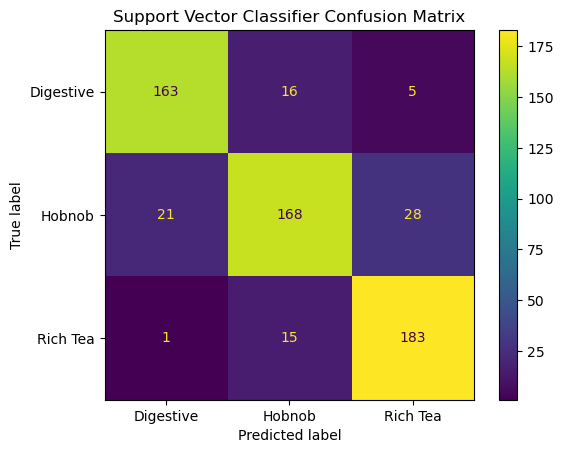

In [10]:
# Calculate the confusion matrix.
svc_conf_matrix = confusion_matrix(dunk_test_targets, svc_predicted_targets)

# Plot the confusion matrix.
fig, ax = plt.subplots()

# Plot the confusion matrix.
ConfusionMatrixDisplay(confusion_matrix=svc_conf_matrix, 
                       display_labels=biscuit_decoded).plot(ax=ax)

# Set the title.
ax.set_title("Support Vector Classifier Confusion Matrix")

plt.show()

#### $\textbf{2.2 Tuned Model}$

+ Tune the parameters of the ***SVC*** model.

In [11]:
# Show the parameters of the SVC model.
display(svc.get_params())

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [12]:
# Create a parameter grid to search over.
svc_param_grid = {
    "C": uniform(loc=0, scale=10),
    "degree": [3, 4, 5, 6],
    "gamma": ["scale", "auto"]
}

# Perform a random search over the parameter grid.
svc_grid = RandomizedSearchCV(estimator=SVC(kernel="rbf"), 
                              param_distributions=svc_param_grid, 
                              scoring="f1_macro", 
                              cv=5, 
                              n_iter=100)
svc_grid.fit(dunk_train_features_scaled, dunk_train_targets)

# Print the best found parameters. 
print(f"SVC Best Parameters: {svc_grid.best_params_}")

# Store the best found SVC model.
svc_optimal = svc_grid.best_estimator_

# Test the best found SVC model.
svc_predicted_targets = svc_optimal.predict(dunk_test_features_scaled)

SVC Best Parameters: {'C': np.float64(6.438347092962121), 'degree': 5, 'gamma': 'auto'}


In [13]:
# Print the classification report.
svc_cr = classification_report(dunk_test_targets, svc_predicted_targets, target_names=biscuit_decoded)
print(svc_cr)

              precision    recall  f1-score   support

   Digestive       0.89      0.94      0.92       184
      Hobnob       0.87      0.84      0.86       217
    Rich Tea       0.92      0.90      0.91       199

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600



In [14]:
# Calculate the F1 score.
svc_f1 = f1_score(dunk_test_targets, svc_predicted_targets, average="macro")
print(f"SVC F1 Score: {svc_f1:.5f}")

SVC F1 Score: 0.89304


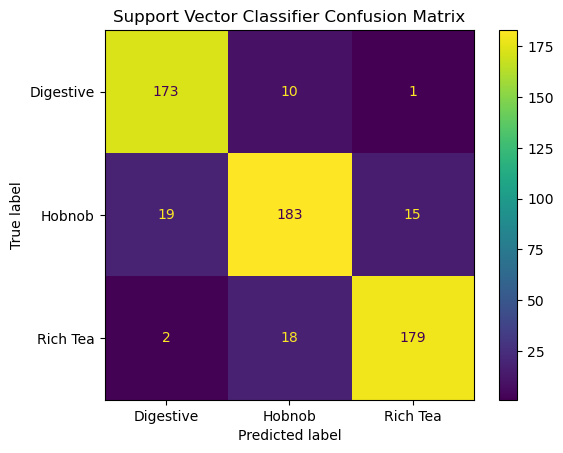

In [15]:
# Calculate the confusion matrix.
svc_conf_matrix = confusion_matrix(dunk_test_targets, svc_predicted_targets)

# Plot the confusion matrix.
fig, ax = plt.subplots()

# Plot the confusion matrix.
ConfusionMatrixDisplay(confusion_matrix=svc_conf_matrix, 
                       display_labels=biscuit_decoded).plot(ax=ax)

# Set the title.
ax.set_title("Support Vector Classifier Confusion Matrix")

plt.show()

#### $\textbf{2.3 Observations}$

+ The SVC model in general performs well both with and without parameter 
tuning.

- The untuned SVC model tends to achieve around 0.80 - 0.85 F1 score (macro).
- The tuned SVC model tends to achieve around 0.85 - 0.90 F1 score (macro).

### $\textbf{3. Random Forest}$

+ Investigate how a ***Random Forest Classifier (RFC)*** performs.

#### $\textbf{3.1 Initial Model}$

+ Define an initial ***RFC*** model.

In [16]:
# Create a Random Forest Classifier (RFC) model.
rfc = RandomForestClassifier()

# Train the RFC model.
rfc.fit(dunk_train_features_scaled, dunk_train_targets)

# Test the RFC model.
rfc_predicted_targets = rfc.predict(dunk_test_features_scaled)

In [17]:
# Print the classification report.
print(classification_report(dunk_test_targets, rfc_predicted_targets, target_names=biscuit_decoded))

              precision    recall  f1-score   support

   Digestive       0.78      0.86      0.82       184
      Hobnob       0.76      0.69      0.72       217
    Rich Tea       0.86      0.86      0.86       199

    accuracy                           0.80       600
   macro avg       0.80      0.81      0.80       600
weighted avg       0.80      0.80      0.80       600



In [18]:
# Calculate the F1 score.
rfc_f1 = f1_score(dunk_test_targets, rfc_predicted_targets, average="weighted")
print(f"RFC F1 Score: {rfc_f1:.5f}")

RFC F1 Score: 0.79832


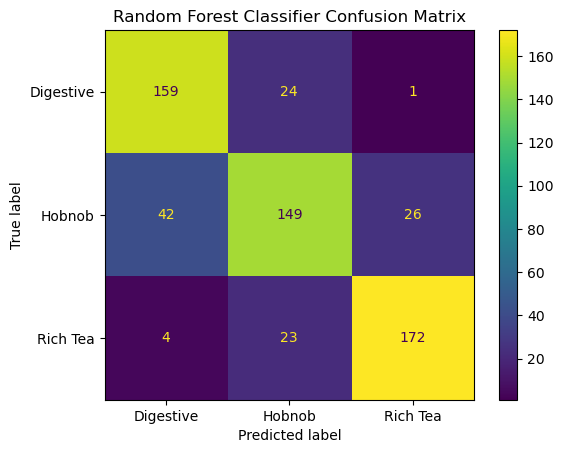

In [19]:
# Calculate the confusion matrix.
rfc_conf_matrix = confusion_matrix(dunk_test_targets, rfc_predicted_targets)

# Plot the confusion matrix.
fig, ax = plt.subplots()

# Plot the confusion matrix.
ConfusionMatrixDisplay(confusion_matrix=rfc_conf_matrix, 
                       display_labels=biscuit_decoded).plot(ax=ax)

# Set the title.
ax.set_title("Random Forest Classifier Confusion Matrix")

plt.show()

#### $\textbf{3.2 Tuned Model}$

+ Tune the parameters of the ***RFC*** model.

In [20]:
# Show the parameters of the RFC model.
display(rfc.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [21]:
# Create a parameter grid to search over.
rfc_param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [10, 25, 50, None],
    "max_features": ["sqrt", None],
    "n_estimators": [100, 150, 200, 250],
}

# Perform a random search over the parameter grid.
rfc_grid = RandomizedSearchCV(estimator=RandomForestClassifier(), 
                              param_distributions=rfc_param_grid, 
                              scoring="f1_macro", 
                              cv=5, 
                              n_iter=50)
rfc_grid.fit(dunk_train_features_scaled, dunk_train_targets)

# Print the best found parameters. 
print(f"RFC Best Parameters: {rfc_grid.best_params_}")

# Store the best found RFC model.
rfc_optimal = rfc_grid.best_estimator_

# Test the best found RFC model.
rfc_predicted_targets = rfc_optimal.predict(dunk_test_features_scaled)

RFC Best Parameters: {'n_estimators': 250, 'max_features': None, 'max_depth': None, 'criterion': 'entropy'}


In [22]:
# Print the classification report.
rfc_cr = classification_report(dunk_test_targets, rfc_predicted_targets, target_names=biscuit_decoded)
print(rfc_cr)

              precision    recall  f1-score   support

   Digestive       0.85      0.93      0.89       184
      Hobnob       0.81      0.80      0.81       217
    Rich Tea       0.93      0.85      0.89       199

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



In [23]:
# Calculate the F1 score.
rfc_f1 = f1_score(dunk_test_targets, rfc_predicted_targets, average="macro")
print(f"RFC F1 Score: {rfc_f1:.5f}")

RFC F1 Score: 0.86212


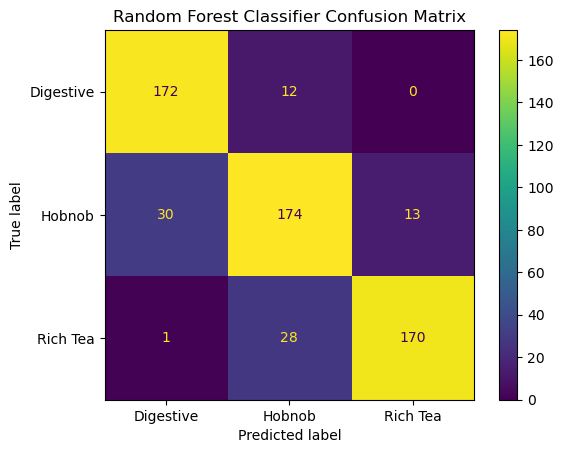

In [24]:
# Calculate the confusion matrix.
rfc_conf_matrix = confusion_matrix(dunk_test_targets, rfc_predicted_targets)

# Plot the confusion matrix.
fig, ax = plt.subplots()

# Plot the confusion matrix.
ConfusionMatrixDisplay(confusion_matrix=rfc_conf_matrix, 
                       display_labels=biscuit_decoded).plot(ax=ax)

# Set the title.
ax.set_title("Random Forest Classifier Confusion Matrix")

plt.show()

#### $\textbf{3.3 Observations}$

+ The RFC model in general performs a little worse than the SVC model both with 
and without parameter tuning.

- The untuned RFC model tends to achieve around 0.76 - 0.82 F1 score (macro).
- The tuned RFC model tends to achieve around 0.82 - 0.86 F1 score (macro).

### $\textbf{4. Neural Network}$

+ Investigate how a ***Neural Network Classifier (NNC)*** performs.

#### $\textbf{4.1 Data Preprocessing}$

+ Preprocess the ***dunking*** data further.

- Split the training data further into training and validation subsets.
- Standardise the features of the different subsets.
- Format the data into ***torch DataLoader*** objects.

In [25]:
# Split the training data further into train and validation subsets.
dunk_nn_train, dunk_nn_val = train_test_split(dunk_train, train_size=0.90, shuffle=True)

# Split the train subset into features and targets.
dunk_nn_train_features = dunk_nn_train.drop(["biscuit", "encoded-biscuit"], axis="columns") 
dunk_nn_train_targets = dunk_nn_train["encoded-biscuit"]

# Split the validation subset into features and targets.
dunk_nn_val_features = dunk_nn_val.drop(["biscuit", "encoded-biscuit"], axis="columns") 
dunk_nn_val_targets = dunk_nn_val["encoded-biscuit"]

In [26]:
# Standardise the train features.
dunk_nn_train_features_scaled = StandardScaler().fit_transform(dunk_nn_train_features)
dunk_nn_train_features_scaled = pd.DataFrame(dunk_nn_train_features_scaled, columns=dunk_nn_train_features.columns)

# Standardise the validation features.
dunk_nn_val_features_scaled = StandardScaler().fit_transform(dunk_nn_val_features)
dunk_nn_val_features_scaled = pd.DataFrame(dunk_nn_val_features_scaled, columns=dunk_nn_val_features.columns)

In [27]:
# Convert the train data to Tensors.
dunk_nn_train_features_scaled = tensor(dunk_nn_train_features_scaled.to_numpy(), dtype=float32)
dunk_nn_train_targets = tensor(dunk_nn_train_targets.to_numpy(), dtype=int64)

# Convert the validation data to Tensors.
dunk_nn_val_features_scaled = tensor(dunk_nn_val_features_scaled.to_numpy(), dtype=float32)
dunk_nn_val_targets = tensor(dunk_nn_val_targets.to_numpy(), dtype=int64)

# Convert the test features to a Tensor.
dunk_nn_test_features = tensor(dunk_test_features_scaled.to_numpy(), dtype=float32)

In [28]:
# Create a TensorDataset and a DataLoader for the train data.
dunk_nn_train_data = TensorDataset(dunk_nn_train_features_scaled, dunk_nn_train_targets)
dunk_nn_train_dataloader = DataLoader(dunk_nn_train_data, batch_size=100, shuffle=True)

# Create a TensorDataset for the validation data.
dunk_nn_val_data = TensorDataset(dunk_nn_val_features_scaled, dunk_nn_val_targets)
dunk_nn_val_dataloader = DataLoader(dunk_nn_val_data, batch_size=100)

# Create a TensorDataset for the test data.
dunk_nn_test_data = TensorDataset(dunk_nn_test_features)
dunk_nn_test_dataloader = DataLoader(dunk_nn_test_data, batch_size=100)

#### $\textbf{4.2 Model}$

+ Train and test the ***NNC*** model.

In [29]:
# Create a Neural Network Classifier (NNC) model.
nnc = FNNClassifier(num_features=len(dunk_nn_train_features.columns), num_classes=len(biscuit_decoded))

# Train the NNC model.
metrics = nnc.fit(train_dataloader=dunk_nn_train_dataloader, 
                  val_dataloader=dunk_nn_val_dataloader, 
                  epochs=500, 
                  learning_rate=0.0001, 
                  patience=10)

# Store the metrics from the training process.
train_losses, val_losses, train_f1s, val_f1s = metrics

Epoch: 1
	Train Loss: 1.11361	Val Loss  : 1.11489
	Train F1  : 0.16799	Val F1    : 0.16603
Epoch: 2
	Train Loss: 1.10869	Val Loss  : 1.11106
	Train F1  : 0.16892	Val F1    : 0.16603
Epoch: 3
	Train Loss: 1.10603	Val Loss  : 1.10766
	Train F1  : 0.16918	Val F1    : 0.16603
Epoch: 4
	Train Loss: 1.10313	Val Loss  : 1.10452
	Train F1  : 0.16883	Val F1    : 0.16603
Epoch: 5
	Train Loss: 1.10078	Val Loss  : 1.10126
	Train F1  : 0.16862	Val F1    : 0.16603
Epoch: 6
	Train Loss: 1.09673	Val Loss  : 1.09810
	Train F1  : 0.16905	Val F1    : 0.16603
Epoch: 7
	Train Loss: 1.09607	Val Loss  : 1.09496
	Train F1  : 0.16866	Val F1    : 0.16603
Epoch: 8
	Train Loss: 1.09210	Val Loss  : 1.09165
	Train F1  : 0.17011	Val F1    : 0.16603
Epoch: 9
	Train Loss: 1.08887	Val Loss  : 1.08776
	Train F1  : 0.17111	Val F1    : 0.16603
Epoch: 10
	Train Loss: 1.08642	Val Loss  : 1.08366
	Train F1  : 0.17827	Val F1    : 0.16603
Epoch: 11
	Train Loss: 1.08166	Val Loss  : 1.07877
	Train F1  : 0.19136	Val F1    : 0.187

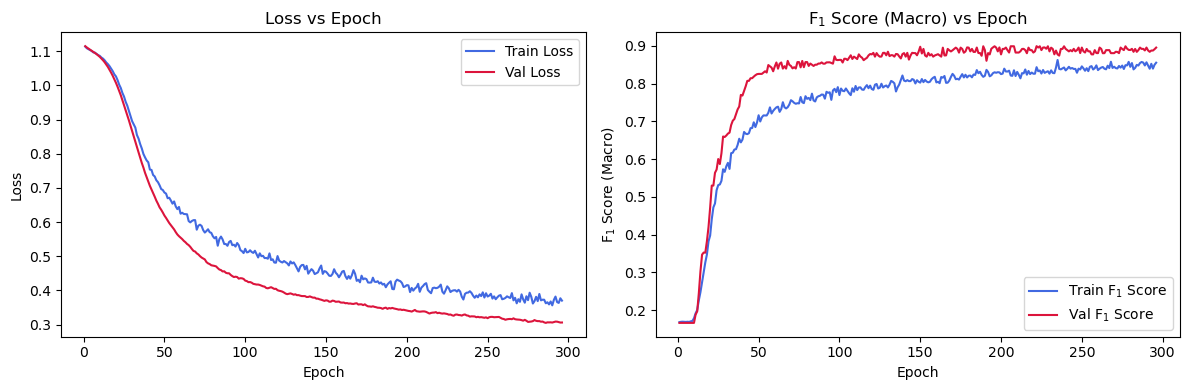

In [30]:
# Plot the metrics from the training process.
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Define the x-values.
x_values = range(1, len(train_losses) + 1)

# Plot the train and validation losses.
ax[0].plot(x_values, train_losses, color="royalblue", label="Train Loss")
ax[0].plot(x_values, val_losses, color="crimson", label="Val Loss")

# Plot the train and validation F1 scores.
ax[1].plot(x_values, train_f1s, color="royalblue", label=r"Train F$_{1}$ Score")
ax[1].plot(x_values, val_f1s, color="crimson", label=r"Val F$_{1}$ Score")

# Set the labels for the 1st plot.
ax[0].set_title("Loss vs Epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")

# Set the labels for the 2nd plot.
ax[1].set_title(r"F$_{1}$ Score (Macro) vs Epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel(r"F$_{1}$ Score (Macro)")

# Set the legends.
ax[0].legend()
ax[1].legend()

fig.tight_layout()
plt.show()

In [31]:
# Test the NNC model.
nnc_predicted_targets = nnc.predict(dunk_nn_test_dataloader)

In [32]:
# Print the classification report.
nnc_cr = classification_report(dunk_test_targets, nnc_predicted_targets, target_names=biscuit_decoded)
print(nnc_cr)

              precision    recall  f1-score   support

   Digestive       0.91      0.93      0.92       184
      Hobnob       0.88      0.80      0.84       217
    Rich Tea       0.87      0.93      0.90       199

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.88      0.89      0.88       600



In [33]:
# Calculate the F1 score.
nnc_f1 = f1_score(dunk_test_targets, nnc_predicted_targets, average="macro")
print(f"NNC F1 Score: {nnc_f1:.5f}")

NNC F1 Score: 0.88619


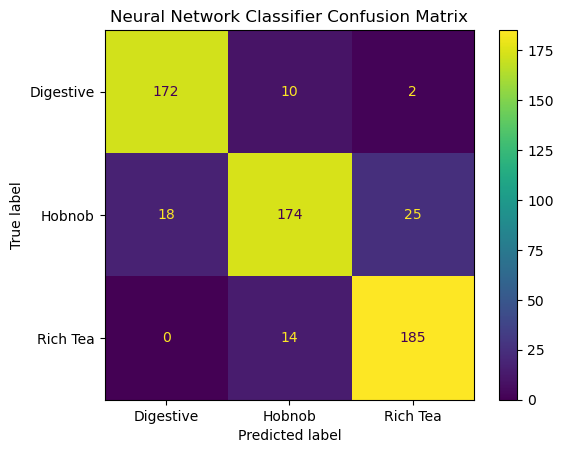

In [34]:
# Calculate the confusion matrix.
nnc_conf_matrix = confusion_matrix(dunk_test_targets, nnc_predicted_targets)

# Plot the confusion matrix.
fig, ax = plt.subplots()

# Plot the confusion matrix.
ConfusionMatrixDisplay(confusion_matrix=nnc_conf_matrix, 
                       display_labels=biscuit_decoded).plot(ax=ax)

# Set the title.
ax.set_title("Neural Network Classifier Confusion Matrix")

plt.show()

#### $\textbf{4.3 Observations}$

+ The NNC model in general outperforms both the SVC and RFC models.
+ However, the SVC model is close in performance and on occasion can outperform 
the NNC model.

- The NNC model tends to achieve around 0.88 - 0.92 F1 score (macro).

### $\textbf{5. Model Comparison}$

+ Compare the different machine learning classifiers.

#### $\textbf{5.1 Class Specific Precision, Recall \& F1 Scores}$

+ Compare class specific scores.

In [35]:
# Print the classification report for the SVC model.
print(f"SVC Classification Report\n" + svc_cr)

SVC Classification Report
              precision    recall  f1-score   support

   Digestive       0.89      0.94      0.92       184
      Hobnob       0.87      0.84      0.86       217
    Rich Tea       0.92      0.90      0.91       199

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600



In [36]:
# Print the classification report for the RFC model.
print(f"RFC Classification Report\n" + rfc_cr)

RFC Classification Report
              precision    recall  f1-score   support

   Digestive       0.85      0.93      0.89       184
      Hobnob       0.81      0.80      0.81       217
    Rich Tea       0.93      0.85      0.89       199

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



In [37]:
# Print the classification report for the NNC model.
print(f"NNC Classification Report\n" + nnc_cr)

NNC Classification Report
              precision    recall  f1-score   support

   Digestive       0.91      0.93      0.92       184
      Hobnob       0.88      0.80      0.84       217
    Rich Tea       0.87      0.93      0.90       199

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.88      0.89      0.88       600



#### $\textbf{5.2 F1 Score - Macro}$

+ Compare $\textbf{F}_{1}$ (macro) scores.

In [38]:
# Print the F1 score for the different models.
print(f"SVC F1 Macro Score: {svc_f1:.5f}")
print(f"RFC F1 Macro Score: {rfc_f1:.5f}")
print(f"NNC F1 Macro Score: {nnc_f1:.5f}")

SVC F1 Macro Score: 0.89304
RFC F1 Macro Score: 0.86212
NNC F1 Macro Score: 0.88619


#### $\textbf{5.3 Cohen Kappa Score}$

+ Compare ***Cohen's Kappa*** scores.

In [39]:
# Calculate the Cohen kappa score for the different models.
svc_ck = cohen_kappa_score(dunk_test_targets, svc_predicted_targets)
rfc_ck = cohen_kappa_score(dunk_test_targets, rfc_predicted_targets)
nnc_ck = cohen_kappa_score(dunk_test_targets, nnc_predicted_targets)

# Print the Cohen kappa score for the different models.
print(f"SVC Cohen Kappa Score: {svc_ck:.5f}")
print(f"RFC Cohen Kappa Score: {rfc_ck:.5f}")
print(f"NNC Cohen Kappa Score: {nnc_ck:.5f}")

SVC Cohen Kappa Score: 0.83730
RFC Cohen Kappa Score: 0.78982
NNC Cohen Kappa Score: 0.82742


#### $\textbf{5.4 Extra - Feature Importance}$

+ Investigate the importance of features in the ***dunking*** data for biscuit 
classification.

In [40]:
# Print the importance of features from the RFC model.
for feature, importance in zip(rfc_optimal.feature_names_in_, rfc_optimal.feature_importances_):
    # Account for formatting.
    if feature != "dynamic-viscosity":
        print(f"{feature}\t\t: {importance:.5f}")
    else:
        print(f"{feature}\t: {importance:.5f}")

surface-tension		: 0.11189
contact-angle		: 0.29313
dynamic-viscosity	: 0.04400
travel-distance		: 0.34293
dunking-time		: 0.20805


#### $\textbf{5.5 Observations}$

+ The NNC model in general tends to outperform the SVC and RFC models across 
all the investigated scores.
+ The SVC model is close in performance to NNC model and on occasion beats the 
NNC model.

- On average we get the following F1 scores (macro) for each of the models.

+ NNC F1 Score (macro) &approx; 0.88 - 0.92 
+ SVC F1 Score (macro) &approx; 0.85 - 0.90
+ RFC F1 Score (macro) &approx; 0.82 - 0.86

### $\textbf{6. Microscope Data Classification}$

+ Perform biscuit classification on the ***microscope*** data (```microscope.csv```).

#### $\textbf{6.1 Data Preprocessing}$

+ Preprocess the ***microscope*** data.

- Standardise the features in the data.
- Format the data into a ***torch DataLoader*** object.

In [41]:
# Read in the microscope data.
microscope = pd.read_csv("../datasets/microscope-data/microscope.csv")

# View the data.
print(microscope.head().to_markdown())

|    |   surface-tension |   contact-angle |   dynamic-viscosity |   travel-distance |   dunking-time |   pore-radius |
|---:|------------------:|----------------:|--------------------:|------------------:|---------------:|--------------:|
|  0 |         0.0845956 |         1.55737 |         0.000981483 |       0.00322055  |        24.2311 |   7.45371e-07 |
|  1 |         0.0642912 |         1.53884 |         0.000997503 |       0.00239506  |        22.1698 |   2.60068e-07 |
|  2 |         0.0862236 |         1.54614 |         0.00100762  |       0.00303645  |        23.2577 |   3.73462e-07 |
|  3 |         0.0828591 |         1.56688 |         0.000997457 |       0.00126069  |        12.7174 |   7.56717e-07 |
|  4 |         0.0908324 |         1.57023 |         0.00100171  |       0.000576075 |        15.1891 |   8.23907e-07 |


In [42]:
# Standardise the features.
micro_features_scaled = StandardScaler().fit_transform(microscope.drop("pore-radius", axis="columns"))
micro_features_scaled = pd.DataFrame(micro_features_scaled, columns=microscope.columns[:-1])

In [43]:
# Create a TensorDataset and a DataLoader for the microscope data.
micro_nn_data = TensorDataset(tensor(micro_features_scaled.to_numpy(), dtype=float32))
micro_nn_dataloader = DataLoader(micro_nn_data, batch_size=100)

#### $\textbf{6.2 Classification}$

+ Perform biscuit classification using the ***NNC*** model.

In [44]:
# Generate predictions.
predictions = nnc.predict(micro_nn_dataloader)

# Decode the predicted labels.
predicted_biscuits = encoder.inverse_transform(predictions)

# Store the predicted labels in a DataFrame.
microscope_classified = microscope.copy()
microscope_classified["biscuit"] = predicted_biscuits

# View the data.
print(microscope_classified.head().to_markdown())

|    |   surface-tension |   contact-angle |   dynamic-viscosity |   travel-distance |   dunking-time |   pore-radius | biscuit   |
|---:|------------------:|----------------:|--------------------:|------------------:|---------------:|--------------:|:----------|
|  0 |         0.0845956 |         1.55737 |         0.000981483 |       0.00322055  |        24.2311 |   7.45371e-07 | Hobnob    |
|  1 |         0.0642912 |         1.53884 |         0.000997503 |       0.00239506  |        22.1698 |   2.60068e-07 | Rich Tea  |
|  2 |         0.0862236 |         1.54614 |         0.00100762  |       0.00303645  |        23.2577 |   3.73462e-07 | Rich Tea  |
|  3 |         0.0828591 |         1.56688 |         0.000997457 |       0.00126069  |        12.7174 |   7.56717e-07 | Rich Tea  |
|  4 |         0.0908324 |         1.57023 |         0.00100171  |       0.000576075 |        15.1891 |   8.23907e-07 | Rich Tea  |


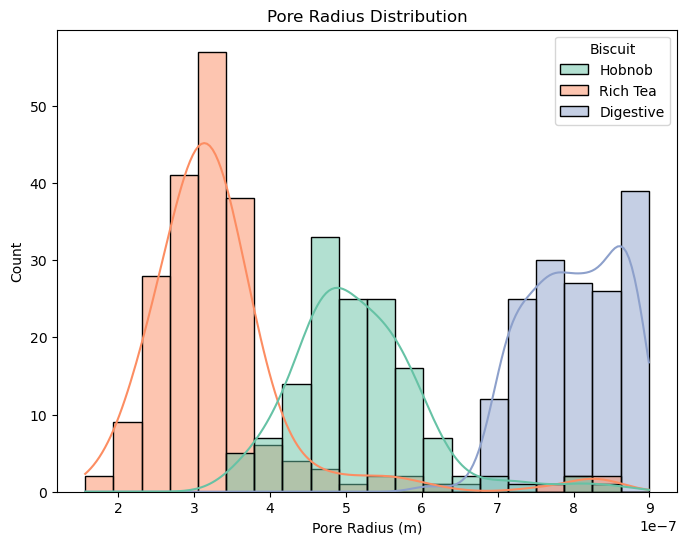

In [45]:
# Plot the distribution of pore-radius values.
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data.
sns.histplot(data=microscope_classified, 
             x="pore-radius",
             hue="biscuit",
             bins=20,
             kde=True, 
             palette="Set2",  
             ax=ax)

# Set the labels.
ax.set_title("Pore Radius Distribution")
ax.set_xlabel("Pore Radius (m)")
ax.set_ylabel("Count")

# Set the legend.
ax.get_legend().set_title("Biscuit")

plt.show()

In [46]:
# Calculate the average pore-radius for each biscuit.
pore_radius_average_classified = microscope_classified.groupby("biscuit")["pore-radius"].mean()
print(pore_radius_average_classified)

biscuit
Digestive    8.010063e-07
Hobnob       5.156666e-07
Rich Tea     3.320979e-07
Name: pore-radius, dtype: float64


In [47]:
# Calculate the standard deviation pore-radius for each biscuit.
pore_radius_std_classified = microscope_classified.groupby("biscuit")["pore-radius"].std()
print(pore_radius_std_classified)

biscuit
Digestive    6.173757e-08
Hobnob       8.469874e-08
Rich Tea     1.033077e-07
Name: pore-radius, dtype: float64


In [48]:
# Save the classified microscope data.
microscope_classified.to_csv("../datasets/microscope-data/microscope-classified.csv", index=False)

##### $\textbf{6.2.1 Observations}$

+ The figure shows that the pore radius values get separated into three groups 
as expected from the ***exploration*** notebook.

- The pore radius values follow a normal distribution for each biscuit with the 
exception of the Digestive biscuit.
- The pore radius values for the Digestive biscuit follow a mix between a 
normal and a uniform distribution.

+ We can now infer the average pore radius of each of the biscuits.

#### $\textbf{6.3 Extra - Error In Brief?}$

+ The brief gives two conflicting descriptions of the ***microscope*** data.

- The first description suggests that the ***microscope*** data is a subset of 
the ***dunking*** data.
- The second description suggests that the ***microscope*** data is ***not*** a 
subset of the ***dunking*** data.

+ In the case of the first description, the true biscuit labels can be 
retrieved through merging the different datasets.
+ The true biscuit labels can then be used to evaluate the performance of the 
***NNC*** model.

- Investigate the first description of the ***microscope*** data.

In [49]:
# Merge labels from the dunking data.
microscope_labelled = microscope.copy()
microscope_labelled = microscope_labelled.merge(dunking.drop("encoded-biscuit", axis="columns"), how="inner")

# View the data.
print(microscope_labelled.head().to_markdown())

|    |   surface-tension |   contact-angle |   dynamic-viscosity |   travel-distance |   dunking-time |   pore-radius | biscuit   |
|---:|------------------:|----------------:|--------------------:|------------------:|---------------:|--------------:|:----------|
|  0 |         0.0845956 |         1.55737 |         0.000981483 |       0.00322055  |        24.2311 |   7.45371e-07 | Digestive |
|  1 |         0.0642912 |         1.53884 |         0.000997503 |       0.00239506  |        22.1698 |   2.60068e-07 | Rich Tea  |
|  2 |         0.0862236 |         1.54614 |         0.00100762  |       0.00303645  |        23.2577 |   3.73462e-07 | Hobnob    |
|  3 |         0.0828591 |         1.56688 |         0.000997457 |       0.00126069  |        12.7174 |   7.56717e-07 | Digestive |
|  4 |         0.0908324 |         1.57023 |         0.00100171  |       0.000576075 |        15.1891 |   8.23907e-07 | Digestive |


In [50]:
# Print the number of samples after the merge.
# This is to confirm all samples exist in the dunking data.
print(microscope_labelled["biscuit"].count())

500


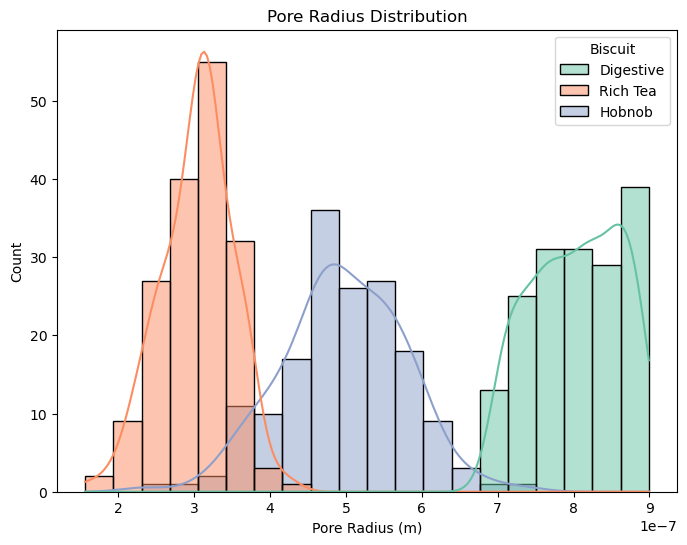

In [51]:
# Plot the distribution of pore-radius values.
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data.
sns.histplot(data=microscope_labelled, 
             x="pore-radius",
             hue="biscuit",
             bins=20,
             kde=True, 
             palette="Set2",  
             ax=ax)

# Set the labels.
ax.set_title("Pore Radius Distribution")
ax.set_xlabel("Pore Radius (m)")
ax.set_ylabel("Count")

# Set the legend.
ax.get_legend().set_title("Biscuit")

plt.show()

In [52]:
# Calculate the average pore-radius for each biscuit.
pore_radius_average_labelled = microscope_labelled.groupby("biscuit")["pore-radius"].mean()
print(pore_radius_average_labelled)

biscuit
Digestive    8.034292e-07
Hobnob       4.963689e-07
Rich Tea     3.038971e-07
Name: pore-radius, dtype: float64


In [53]:
# Calculate the standard deviation of the pore-radius for each biscuit.
pore_radius_std_labelled = microscope_labelled.groupby("biscuit")["pore-radius"].std()
print(pore_radius_std_labelled)

biscuit
Digestive    5.817930e-08
Hobnob       8.027767e-08
Rich Tea     4.716600e-08
Name: pore-radius, dtype: float64


In [54]:
# Calculate the F1 score of the model predicted labels.
nnc_f1_microscope = f1_score(microscope_labelled["biscuit"], microscope_classified["biscuit"], average="macro")
print(f"NNC F1 Macro Score: {nnc_f1_microscope:.5f}")

NNC F1 Macro Score: 0.90308


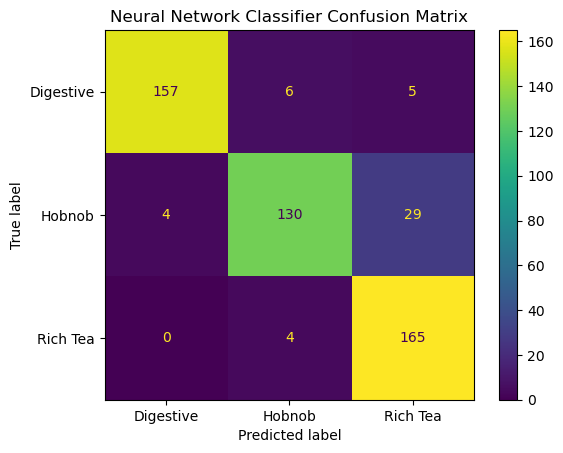

In [55]:
# Calculate the confusion matrix.
nnc_conf_matrix_microscope = confusion_matrix(microscope_labelled["biscuit"], microscope_classified["biscuit"])

# Plot the confusion matrix.
fig, ax = plt.subplots()

# Plot the confusion matrix.
ConfusionMatrixDisplay(confusion_matrix=nnc_conf_matrix_microscope, 
                       display_labels=biscuit_decoded).plot(ax=ax)

# Set the title.
ax.set_title("Neural Network Classifier Confusion Matrix")

plt.show()

##### $\textbf{6.3.1 Observations}$

+ We find that the microscope data is indeed a subset of the dunking data.
+ The datasets can be merged with all 500 samples in the microscope data having 
exact matches in the dunking data.

- This means that true labels of the microscope data can be used to evaluate 
the performance of the NNC model.

+ However, this also means that the microscope data is not a true "unseen" 
dataset as the model was trained on the dunking data.
+ This means that an overfitted model could perform better than a well 
generalised model.

- In general the NNC model achieves around an 0.90 F1 score (macro).